# TensorFlow Script Mode - Using Shell scripts

Starting from TensorFlow version 1.11, you can use a shell script as
your training entry point. Shell scripts are useful for many use cases including:

- Invoking Python scripts with specific parameters
- Configuring framework dependencies
- Training using different programming languages

For this example, we use [a Keras implementation of the Deep Dream algorithm](https://github.com/keras-team/keras/blob/2.2.4/examples/deep_dream.py). We can use the same technique for other scripts or repositories including [TensorFlow Model Zoo](https://github.com/tensorflow/models) and [TensorFlow benchmark scripts](https://github.com/tensorflow/benchmarks/tree/master/scripts/tf_cnn_benchmarks).

# Getting the image for training
For training data, let's download a public domain image:

In [1]:
import os
data_dir = os.path.join(os.getcwd(), 'training')

os.makedirs(data_dir, exist_ok=True)
data_dir

'/home/ec2-user/SageMaker/AWS-ML-Certification/__my_study/by_type/frameworks/tensorflow/tensorflow_script_mode_using_shell_commands/training'

In [ ]:
!wget -O training/dark-forest-landscape.jpg https://www.goodfreephotos.com/albums/other-landscapes/dark-forest-landscape.jpg

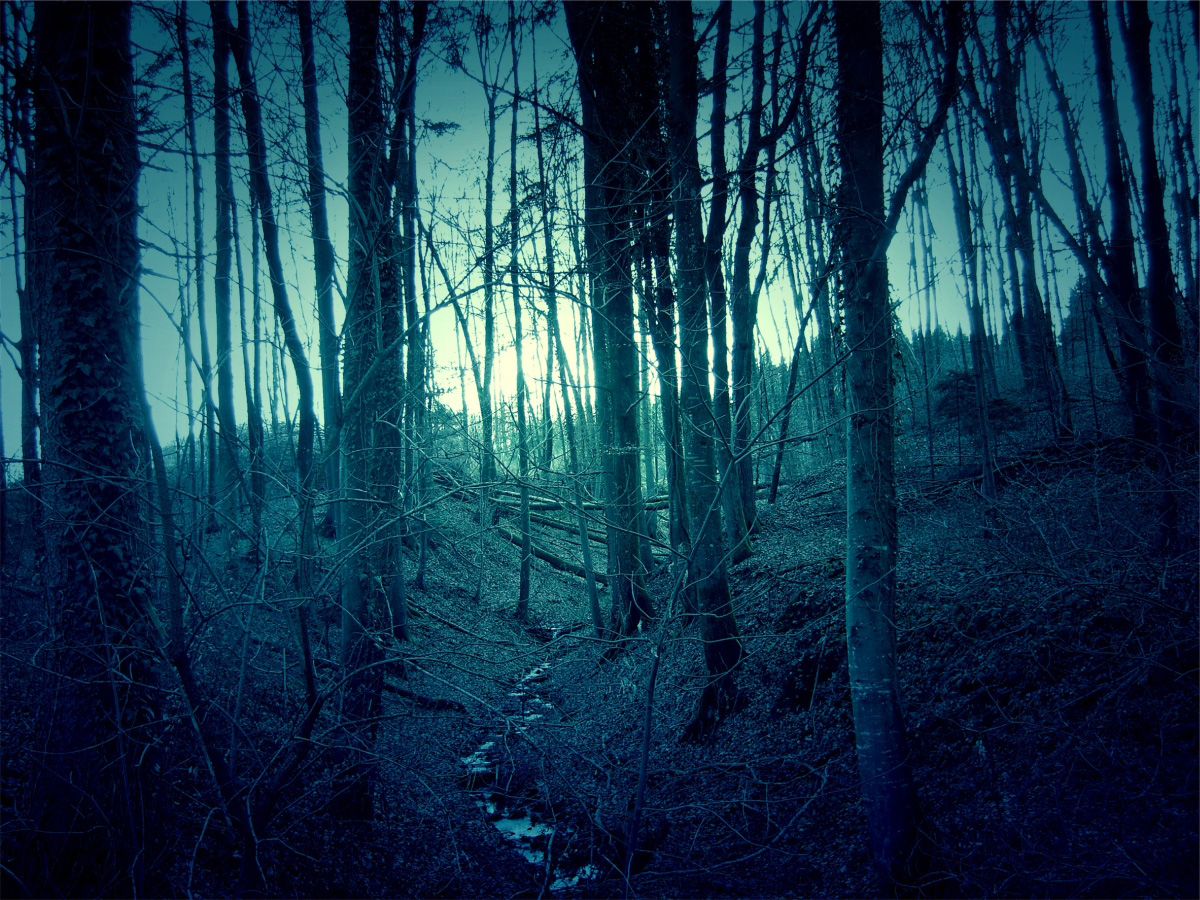

In [2]:
from IPython.display import Image
Image(filename='training/dark-forest-landscape.jpg') 

## Download the training script

Let's start by downloading the [deep_dream](https://github.com/keras-team/keras/blob/2.2.4/examples/deep_dream.py) example script from Keras repository. This script takes an image and uses deep dream algorithm to generate
transformations of that image.

In [ ]:
!wget https://raw.githubusercontent.com/keras-team/keras/2.2.4/examples/deep_dream.py

The script **deep_dream.py** takes two positional arguments:
- `base_image_path`: Path to the image to transform.
- `result_prefix`: Prefix of all generated images.

### Creating the launcher script

We need to create a launcher script that sets the `base_image_path` 
and `result_prefix`, and invokes **deep_dream.py**:

In [ ]:

%%writefile launcher.sh 

BASE_IMAGE_PATH="${SM_CHANNEL_TRAINING}/dark-forest-landscape.jpg"
RESULT_PREFIX="${SM_MODEL_DIR}/dream"

python deep_dream.py ${BASE_IMAGE_PATH} ${RESULT_PREFIX}

echo "Generated image $(ls ${SM_MODEL_DIR})"

**SM_CHANNEL_TRAINING** and **SM_MODEL** are environment variables created by the SageMaker TensorFlow
Container in the beginning of training. Let's take a more detailed look at then: 

- **SM_MODEL_DIR**: the directory inside the container where the training model data must be saved inside the container, i.e. /opt/ml/model.
- **SM_TRAINING_CHANNEL**: the directory containing data in the 'training' channel. 

For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers#list-of-provided-environment-variables-by-sagemaker-containers).

## Test locally using SageMaker Python SDK TensorFlow Estimator
You can use the SageMaker Python SDK TensorFlow estimator to easily train locally and in SageMaker.
Let's set **launcher.sh** as the entry-point and **deep_dream.py** as a dependency:

In [3]:
entry_point='launcher.sh'
dependencies=['deep_dream.py']

For more information about the arguments `entry_point` and `dependencies` see the [SageMaker TensorFlow](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst#sagemakertensorflowtensorflow-class) documentation.

This notebook shows how to use the SageMaker Python SDK to run your code in a local container before deploying to SageMaker's managed training or hosting environments. Just change your estimator's train_instance_type to local or local_gpu. For more information, see: https://github.com/aws/sagemaker-python-sdk#local-mode.

In order to use this feature you'll need to install docker-compose (and nvidia-docker if training with a GPU). Running following script will install docker-compose or nvidia-docker-compose and configure the notebook environment for you.

Note, you can only run a single local notebook at a time.

In [4]:
!/bin/bash ./setup.sh

The user has root access.
     |████████████████████████████████| 139 kB 1.7 MB/s 
     |████████████████████████████████| 143 kB 5.4 MB/s 
     |████████████████████████████████| 200 kB 6.0 MB/s 
     |████████████████████████████████| 206 kB 4.8 MB/s 
     |████████████████████████████████| 961 kB 6.1 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=500a22f722bc22a54ad6810ebf04b59d02a537cf1c5f6ff563f012cbe1f09fbc
  Stored in directory: /home/ec2-user/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
  Created wheel for dockerpty: filename=dockerpty-0.4.1-py3-none-any.whl size=16604 sha256=65e76e5ee202c55218f4d1cf6b85f6d4fc82c9b36d2043af0023f331936e92dd
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0b/40/ea/b275182c42dc7be184c36518d42999bc5267268af2639e409b
Successfully built docopt dockerpty
Error: argument "agent" is wrong: table id value is inv

Let's train locally here to make sure everything runs smoothly first.

In [ ]:
train_instance_type='local'

We create the TensorFlow Estimator, passing the flag `script_mode=True`. For more information about script mode, see https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst#preparing-a-script-mode-training-script:

In [5]:
role = 'arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200530T112594'

In [ ]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(entry_point=entry_point,
                       dependencies=dependencies,
                       train_instance_type='local',
                       train_instance_count=1,
                    #    role=sagemaker.get_execution_role(),
                       role=role,
                       framework_version='1.14',
                       py_version='py3',
                       script_mode=True)

To start a training job, we call `estimator.fit(inputs)`, where inputs is a dictionary where the keys, named **channels**, have values pointing to the data location:

In [ ]:
inputs = {'training': f'file://{data_dir}'}

estimator.fit(inputs)

In [6]:
estimator.model_data

NameError: name 'estimator' is not defined

`estimator.model_data` contains the S3 location where the contents of **/opt/ml/model**
were save as tar.gz file. Let's untar and download the model:

In [ ]:
!aws s3 cp {estimator.model_data} model.tar.gz
!tar -xvzf model.tar.gz

We can see the resulting image now:

In [ ]:
from IPython.display import Image
Image(filename='dream.png')

# Training in SageMaker

After you test the training job locally, upload the dataset to an S3 bucket so SageMaker can access the data during training:

In [7]:
import sagemaker
bucket = 'md-labs-bucket'
training_data = sagemaker.Session().upload_data(bucket=bucket, path='training', key_prefix='md-labs-tensorflow-datasets/deep-dream')

The `upload_data` call above returns an S3 location that can be used during the SageMaker Training Job

In [8]:
training_data

's3://md-labs-bucket/md-labs-tensorflow-datasets/deep-dream'

To train in SageMaker: change the estimator argument **train_instance_type** to any SageMaker ML Instance Type available for training.


In [10]:
import sagemaker
from sagemaker.tensorflow import TensorFlow


In [11]:
estimator = TensorFlow(entry_point='launcher.sh',
                       dependencies=['deep_dream.py'],
                       train_instance_type='ml.c4.xlarge',
                       train_instance_count=1,
                    #    role=sagemaker.get_execution_role(),
                       role=role,
                       framework_version='1.14',
                       py_version='py3',
                       script_mode=True)


The `estimator.fit` call bellow starts training and creates a data channel named `training` with the contents of the
 S3 location `training_data`.

In [12]:
estimator.fit(training_data)

2020-06-03 18:21:41 Starting - Starting the training job...
2020-06-03 18:21:45 Starting - Launching requested ML instances......
2020-06-03 18:22:51 Starting - Preparing the instances for training...
2020-06-03 18:23:27 Downloading - Downloading input data...
2020-06-03 18:24:08 Training - Training image download completed. Training in progress../usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framewo